In [1]:
import bayes3d as b
import os
import jax.numpy as jnp
import jax
import bayes3d.genjax
#import genjax
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# need to download BOP assets

# model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
# obj_idx = 4
# mesh_filename = os.path.join(model_dir,"obj_" + "{}".format(obj_idx+1).rjust(6, '0') + ".ply")
SCALING_FACTOR = 1.0/1000.0

mesh_filename = 'colmap_reconstruction/compressed_air/dense/meshed-poisson.ply'

In [3]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=500.0, fy=500.0,
    cx=50.0, cy=50.0,
    near=0.01, far=10.0#100.0#50.0
)
b.setup_renderer(intrinsics)
b.RENDERER.add_mesh_from_file(mesh_filename, scaling_factor=SCALING_FACTOR)

: 

: 

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [5]:
#b.RENDERER.meshes[0]
obj_dims, obj_pose = b.utils.aabb(b.RENDERER.meshes[0].vertices)
obj_dims

Array([0.09715   , 0.06662   , 0.19140801], dtype=float32)

In [ ]:
#b.RENDERER.meshes[0]
obj_dims, obj_pose = b.utils.aabb(b.RENDERER.meshes[0].vertices)
obj_dims

Array([0.09715   , 0.06662   , 0.19140801], dtype=float32)

In [6]:
plane_scale = 5
plane_dims = jnp.array([plane_scale * obj_dims[0], plane_scale * obj_dims[1], 0.001])

In [7]:
table_mesh = b.utils.make_cuboid_mesh(plane_dims)
table_mesh.vertices = table_mesh.vertices - jnp.array([0,0,obj_dims[2]/2.0])
b.RENDERER.add_mesh(table_mesh, center_mesh=False)

In [8]:
b.clear()
b.show_trimesh('0',b.RENDERER.meshes[0])
b.show_trimesh('1',b.RENDERER.meshes[1])

In [9]:
## plane detection step
## online with clutter in the rest of the scene

In [10]:
object_poses = jnp.array([b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
            jnp.array([0.0, 2, 2]), # was 0.6
            jnp.array([0.0, 0.0, 0.0]),
            jnp.array([0.0, 0.0, 1.0]),
        )) @ b.t3d.transform_from_axis_angle(jnp.array([0.0, 0.0, 1.0]), angle)  for angle in jnp.linspace(-jnp.pi, jnp.pi, 6)[:-1]]) # was 7


In [ ]:
object_poses_repeat = jnp.tile(object_poses[:,None,...],(1,2,1,1))
object_poses_repeat.shape

(5, 2, 4, 4)

In [ ]:
observations = b.RENDERER.render_many(object_poses_repeat, jnp.array([0,1]))

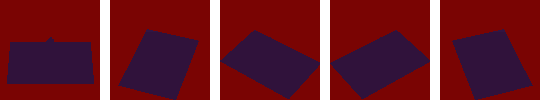

In [ ]:
b.hstack_images([b.get_depth_image(o[...,2]) for o in observations])

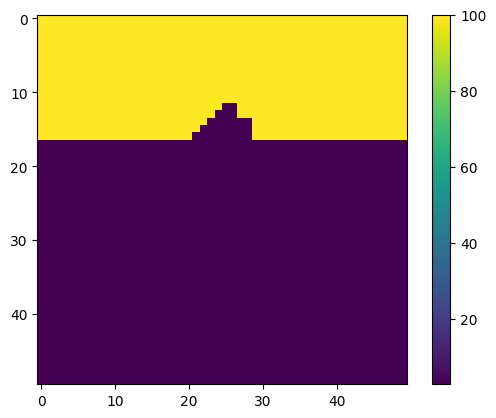

In [ ]:
import matplotlib.pyplot as plt
im1 = observations[0,...,2]
plt.imshow(im1[25:75,25:75])
plt.colorbar()

In [ ]:
grid = b.utils.make_translation_grid_enumeration_3d(
    -0.2, -0.2, -0.2,
    0.2, 0.2, 0.2,
    100, 100, 100
    # 60, 60, 60
)
b.clear()
b.show_cloud("grid", grid)

In [ ]:
grid.shape

(1000000, 3)

In [ ]:
voxel_occupied_occluded_free_parallel = jax.jit(jax.vmap(b.utils.voxel_occupied_occluded_free, in_axes=(0, 0, None, None, None)))

In [ ]:
observations.shape

(5, 100, 100, 4)

In [ ]:
# def v_o(camera_pose, depth_image, grid, intrinsics, tolerance):
#     grid_in_cam_frame = b.t3d.apply_transform(grid,b.t3d.inverse_pose(camera_pose))
#     pixels = b.project_cloud_to_pixels(grid_in_cam_frame, intrinsics).astype(jnp.int32)
#     real_depth_vals = depth_image[pixels[:,1],pixels[:,0]]
#     projected_depth_vals = grid_in_cam_frame[:,2]
#     occupied = jnp.abs(real_depth_vals - projected_depth_vals) < tolerance
#     occluded = real_depth_vals < projected_depth_vals
#     occluded = occluded * (1.0 - occupied)
#     free = (1.0 - occluded) * (1.0 - occupied)
#     return 1.0 * occupied + 0.5 * occluded 

# occupancies = v_o(
#     b.t3d.inverse_pose(object_poses)[0], observations[0,...,2], grid, intrinsics, 0.001
# )

In [ ]:
# occupancies.sum()

In [ ]:
occupancies = voxel_occupied_occluded_free_parallel(
    b.inverse_pose(object_poses), observations[...,2], grid, intrinsics, 0.001
)
print(occupancies.sum())

595952.0


In [ ]:
occupancies.shape
# this is shape across frames

(5, 1000000)

In [ ]:
b.clear()
obj_table_cloud = grid[(occupancies > 0.6).sum(0) > 0 ]
b.show_cloud("cloud", obj_table_cloud)
# b.show_cloud("grid2", grid[occupancy == 0.5],color=b.RED)

In [ ]:
obj_table_cloud.shape

(10862, 3)

In [ ]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(obj_table_cloud)
#pcd.estimate_normals()

In [27]:
"""
print('run Poisson surface reconstruction')
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd, depth=9)
print(mesh)
o3d.visualization.draw_geometries([mesh],
                                  zoom=0.664,
                                  front=[-0.4761, -0.4698, -0.7434],
                                  lookat=[1.8900, 3.2596, 0.9284],
                                  up=[0.2304, -0.8825, 0.4101])
"""

"\nprint('run Poisson surface reconstruction')\nwith o3d.utility.VerbosityContextManager(\n        o3d.utility.VerbosityLevel.Debug) as cm:\n    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(\n        pcd, depth=9)\nprint(mesh)\no3d.visualization.draw_geometries([mesh],\n                                  zoom=0.664,\n                                  front=[-0.4761, -0.4698, -0.7434],\n                                  lookat=[1.8900, 3.2596, 0.9284],\n                                  up=[0.2304, -0.8825, 0.4101])\n"

In [28]:
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape( # create_from_point_cloud_poisson for future use, depth=9
        pcd, 10000)
print(mesh)

[Open3D DEBUG] [CreateFromPointCloudAlphaShape] ComputeDelaunayTetrahedralization
[Open3D DEBUG] [CreateFromPointCloudAlphaShape] done ComputeDelaunayTetrahedralization
[Open3D DEBUG] [CreateFromPointCloudAlphaShape] init triangle mesh
[Open3D DEBUG] [CreateFromPointCloudAlphaShape] done init triangle mesh
[Open3D DEBUG] [CreateFromPointCloudAlphaShape] add triangles from tetras that satisfy constraint
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] inval

In [29]:
mesh
o3d.io.write_triangle_mesh('learned_mesh.ply',mesh)

True

In [30]:
import trimesh
b.clear()
tm = trimesh.load('learned_mesh.ply')
b.show_trimesh("cloud", tm)

In [31]:
mesh = b.utils.make_voxel_mesh_from_point_cloud(grid[(occupancies > 0.6).sum(0) > 0 ], 0.01 )
# we can run a better mesher with the native trimesh mesher?

# compare hypothesis of adding an individual object (uncertainty when leaving it free vs filling in with an object)

In [32]:
b.clear()
b.show_trimesh("mesh", mesh)

In [33]:
## zoom out enough and no weird clipping effects on the border?
## why are there weird connected components when the scaling is set badly in the first place?

In [34]:
from bayes3d.viz.open3dviz import Open3DVisualizer

In [35]:
scaled_up_intrinsics = b.camera.scale_camera_parameters(intrinsics, 2)

In [36]:
viz = Open3DVisualizer(scaled_up_intrinsics)

: 

: 

In [ ]:
distinct_colors = b.viz.distinct_colors(10)

In [ ]:
viz.make_trimesh(mesh, jnp.eye(4),  jnp.array([*distinct_colors[0], 1.0]))

In [ ]:
view_poses = jnp.array([b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
            jnp.array([0.0, 0.9, 0.9]),
            jnp.array([0.0, 0.0, 0.0]),
            jnp.array([0.0, 0.0, 1.0]),
        )) @ b.t3d.transform_from_axis_angle(jnp.array([0.0, 0.0, 1.0]), angle)  for angle in jnp.linspace(-jnp.pi, jnp.pi, 100)[:-1]])

In [ ]:
images = []
for p in tqdm(view_poses):
    images.append(viz.capture_image(intrinsics, b.inverse_pose(p)))

100%|██████████| 99/99 [00:53<00:00,  1.86it/s]


In [ ]:
b.viz.make_gif_from_pil_images([b.get_rgb_image(rgbd.rgb) for rgbd in images], "out.gif",fps=5)

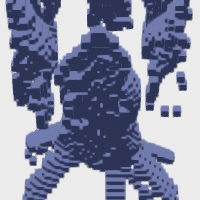

In [ ]:
b.get_rgb_image(viz.capture_image(intrinsics, b.inverse_pose(view_poses[0])).rgb)